# 002_07_differential_photometry_target_PS1

## 필요한 모듈

이 프로젝트를 위해서는 아래의 모듈이 필요하다. 

> numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ccdproc, version_information

### 모듈 설치

1. 콘솔 창에서 모듈을 설치할 때는 아래와 같은 형식으로 입력하면 된다.

>pip install moduleme==version

>conda install module_name=version

2. 주피터 노트북(코랩 포함)에 설치 할 때는 아래의 셀을 실행해서 실행되지 않은 모듈을 설치할 수 있다. (pip 기준) 만약 아나콘다 환경을 사용한다면 7행을 콘다 설치 명령어에 맞게 수정하면 된다.

### 모듈 버전 확인

아래 셀을 실행하면 이 노트북을 실행한 파이썬 및 관련 모듈의 버전을 확인할 수 있다.

In [76]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ysfitsutilpy, ysphotutilpy, ccdproc, sep, aplpy, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        print(f"**** module {pkg} is being installed")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
    else: 
        print(f"**** module {pkg} is installed")

%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

**** module numpy is installed
**** module pandas is installed
**** module matplotlib is installed
**** module scipy is installed
**** module astropy is installed
**** module astroquery is installed
**** module photutils is installed
**** module ysfitsutilpy is installed
**** module ysphotutilpy is installed
**** module ccdproc is installed
**** module sep is installed
**** module aplpy is installed
**** module version_information is installed
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2025-03-03 12:41:01 (KST = GMT+0900) 
0 Python     3.10.16 64bit [GCC 11.2.0]
1 IPython    8.30.0
2 OS         Linux 6.11.0 17 generic x86_64 with glibc2.39
3 numpy      1.26.4
4 pandas     2.2.3
5 matplotlib 3.9.4
6 scipy      1.14.1
7 astropy    6.1.3
8 astroquery 0.4.7
9 photutils  1.12.0
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdproc    
13 sep        1.2.1
14 aplpy      2.2.0
15 version_information 1.

This notebook was generated at 2024-09-25 20:50:10 (KST = GMT+0900) 
0 Python     3.12.3 64bit [GCC 11.2.0]
1 IPython    8.25.0
2 OS         Linux 5.15.0 122 generic x86_64 with glibc2.31
3 numpy      1.26.4
4 pandas     2.2.2
5 matplotlib 3.8.4
6 scipy      1.13.1
7 astropy    6.1.0
8 astroquery 0.4.7
9 photutils  1.12.0
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdproc    2.4.2
13 aplpy      2.1.0
14 version_information 1.0.4

0 Python     3.12.3 64bit [GCC 11.2.0]
1 IPython    8.25.0
2 OS         Linux 5.15.0 119 generic x86_64 with glibc2.31
3 numpy      1.26.4
4 pandas     2.2.2
5 matplotlib 3.8.4
6 scipy      1.13.1
7 astropy    6.1.0
8 astroquery 0.4.7
9 photutils  1.12.0
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdproc    2.4.2
13 aplpy      2.1.0
14 version_information 1.0.4

### import modules

In [77]:
#%%
from glob import glob
from pathlib import Path
import os
import platform
import requests
from datetime import datetime
import numpy as np
import pandas as pd
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
from ccdproc import combine, ccd_process, CCDData

from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

import _astro_utilities
import _Python_utilities

from astropy.nddata import Cutout2D
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clip, sigma_clipped_stats
from photutils.centroids import centroid_com

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.aperture import aperture_photometry as apphot

from astroquery.simbad import Simbad
from urllib.parse import urlencode

from scipy.optimize import curve_fit

import matplotlib
matplotlib.use('Agg')
plt.rcParams.update({'figure.max_open_warning': 0})

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [78]:
#######################################################
# for log file
log_dir = "logs/"
log_file = "{}{}.log".format(log_dir, '02_07_differential_photometry_target_PS1')
err_log_file = "{}{}_err.log".format(log_dir, '02_07_differential_photometry_target_PS1')
print ("log_file: {}".format(log_file))
print ("err_log_file: {}".format(err_log_file))
if not os.path.exists('{0}'.format(log_dir)):
    os.makedirs('{0}'.format(log_dir))

log_file: logs/02_07_differential_photometry_target_PS1.log
err_log_file: logs/02_07_differential_photometry_target_PS1_err.log


In [79]:
#%%
count_stars = False
verbose = True
tryagain = True
trynightsky = False
tryASTROMETRYNET = True
file_age = 60
file_retry_dt = datetime(2025, 3, 1, 15)
file_retry_dt = datetime.now()
downsample = 4
#######################################################
BASEDIR = Path("/mnt/Rdata/ASTRO_data")  
if platform.system() == "Windows":
    BASEDIR = Path("R:\\ASTRO_data")

PROJECDIR = BASEDIR / "C1-Variable"
TODODIR = PROJECDIR / "-_-_-_2016-_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2017-03_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2017-05_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2017-06_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2021-10_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2022-01_-_RiLA600_STX-16803_-_2bin"

# PROJECDIR = BASEDIR / "C2-Asteroid"
# TODODIR = PROJECDIR / "-_-_-_2022-_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2022-_-_RiLA600_STX-16803_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2022-_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2023-_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2023-_-_RiLA600_STX-16803_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2023-_-_RiLA600_STX-16803_-_2bin"

# PROJECDIR = BASEDIR / "C3-EXO"
# TODODIR = PROJECDIR / "-_-_-_2024-05_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2024-05_-_RiLA600_STX-16803_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2024-06_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2024-06_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2024-09_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2024-09_-_RiLA600_ASI6200MMPro_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2024-11_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin"
# TODODIR = PROJECDIR / "-_-_-_2025-01_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2025-01_-_RiLA600_ASI6200MMPro_-_3bin"
# TODODIR = PROJECDIR / "-_-_-_2025-02_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2025-02_-_RiLA600_ASI6200MMPro_-_3bin"

# PROJECDIR = BASEDIR / "C4-Spectra"
# TODODIR = PROJECDIR / "-_-_-_2024-05_TEC140_ASI183MMPro_-_1bin"

# PROJECDIR = BASEDIR / "C5-Test"
# TODODIR = PROJECDIR / "-_-_-_-_GSON300_STF-8300M_-_1bin"

DOINGDIRs = sorted(_Python_utilities.getFullnameListOfsubDirs(TODODIR))
if verbose == True :
    print ("DOINGDIRs: ", format(DOINGDIRs))
    print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

try : 
    BDFDIR = [x for x in DOINGDIRs if "CAL-BDF" in str(x)]
    print ("BDFDIR: ", format(BDFDIR))
    MASTERDIR = Path(BDFDIR[0]) / _astro_utilities.master_dir
    if not MASTERDIR.exists():
        os.makedirs("{}".format(str(MASTERDIR)))
        print("{} is created...".format(str(MASTERDIR)))
    print ("MASTERDIR: ", format(MASTERDIR))
except Exception as err :
    print("X"*60)
    _Python_utilities.write_log(err_log_file, f'''{fpath}, {str(err)}''', verbose=verbose)
    pass

filter_strs = ['LIGHT',
                # '2025-02',
                # 'GPX-1b',
                # 'HAT',
                # 'WASP',
                ]  # Example list of filter strings
DOINGDIRs = [x for x in DOINGDIRs if all(filter_str in str(x) for filter_str in filter_strs)]

rm_filter_strs = [
                # 'GPX-1b',
                # 'HAT',
                # 'WASP',
                # 'Bad_fits', 
                #   'Another_bad_string',
                  ]  # Example list of filter strings to remove
DOINGDIRs = [x for x in DOINGDIRs if not any(rm_filter_str in str(x) for rm_filter_str in rm_filter_strs)]

if verbose == True :
    print ("DOINGDIRs: ", DOINGDIRs)
    print ("len(DOINGDIRs): ", len(DOINGDIRs))
#######################################################

DOINGDIRs:  ['/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/-_CAL-BDF_-_2016-09_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-03_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-08_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-09_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-13_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-11-08_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-11-11_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LI

In [80]:
#%%
#####################################################################
# Observed location
LOCATION = dict(lon=127.005, lat=37.308889, elevation=101)
GSHS =  EarthLocation(lon=127.005 * u.deg, 
                                 lat=37.308889 * u.deg, 
                                 height=101 * u.m)
observatory_code = "P64"

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 4

# Photometry parameters
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus

Mag_target = 12.5
Mag_delta_INIT = 2
ERR_Minimum = 0.5

coord_delta = 0.0001
# Mag_target = 11
# Mag_delta = 2
# ERR_Minimum = 0.5
#######################################################

In [81]:
#%%
for DOINGDIR in DOINGDIRs[-1:] :
    DOINGDIR = Path(DOINGDIR)
    if verbose == True :
        print("DOINGDIR", DOINGDIR)

    foldername_el = DOINGDIR.parts[-1].split("_")
    targ_name = foldername_el[0]
    targme = targ_name.replace("-"," ")

    obsdate = foldername_el[3]
    bin = foldername_el[-1][0]
    
    if verbose == True :
        print("targme :", targme)
        print("obsdate :", obsdate)
        print("bin :", bin)

    if DOINGDIR.parts[-3] == "C1-Variable" :
        targ_info = _astro_utilities.get_variable_star_info(targme, verbose=verbose)
        if targ_info:
            print(f"Variable Star Info for {targme}:")
            for key, value in targ_info.items():
                print(f"{key}: {value}")
            star_name = targ_info['Star Name']
            star_info = _astro_utilities.get_star_info(star_name, verbose=verbose)
            print(type(star_info))
        else:
            print(f"No information found for {targ_name}.")

    if DOINGDIR.parts[-3] == "C3-EXO" :
        nasa_exoplanet_archive = _astro_utilities.NASAExoplanetArchive()
        targ_info = nasa_exoplanet_archive.get_exoplanet_orbital_info(targ_name)
        if targ_info:
            print(f"Orbital information for {targ_name}:")
            for key, value in targ_info.items():
                print(f"{key}: {value}")
            star_name = targ_info['hostname']
            star_name = star_name.replace("-"," ")
            star_info = _astro_utilities.get_star_info(star_name, verbose=verbose)
            print(type(star_info))
            try :
                Mag_target = int(star_info['V Magnitude'])  # Convert the average magnitude to an integer
            except :
                pass
            # if Mag_target <= 12 : 
            #     Mag_target = 12
            # elif Mag_target >= 15 :
            #     Mag_target = 15
        else:
            print(f"No orbital information found for {targ_name}.")
    df_targ = pd.DataFrame([star_info])
    if verbose == True:
        print(f"starname: {star_name}")
        print("Mag_target:", Mag_target)
        print("star_info:", star_info)
        print("df_targ:", df_targ)

    READINGDIR = DOINGDIR / _astro_utilities.reduced_dir
    # READINGDIR = DOINGDIR / _astro_utilities.reduced_nightsky_dir

    DIFFPRESULTDIR = DOINGDIR / f"{READINGDIR.parts[-1]}_DPhot_target_Mag{Mag_target}_fw{FWHM_INIT}"
    if not DIFFPRESULTDIR.exists():
        os.makedirs("{}".format(str(DIFFPRESULTDIR)))
        if verbose == True :
            print("{} is created...".format(str(DIFFPRESULTDIR)))

    summary = yfu.make_summary(READINGDIR/"*.fit*",
                                    verify_fix=True,
                                    ignore_missing_simple=True,
                                    verbose = verbose,)
    if summary is not None : 
        if verbose == True :
            print("len(summary):", len(summary))
            #print("summary:", summary)
            #print(summary["file"][0])
        df_light = summary.loc[summary["IMAGETYP"] == "LIGHT"].copy()
        df_light = df_light.reset_index(drop=True)
        if verbose == True :
            print("df_light:\n{}".format(df_light))


DOINGDIR /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/TT-ARI_LIGHT_-_2016-12-15_-_RiLA600_STX-16803_-_2bin
targme : TT ARI
obsdate : 2016-12-15
bin : 2
Variable Star Info for TT ARI:
Star Name: TT ARI
RA: 02 06 53.09
DEC: +15 17 41.8
Magnitude: None
Variability Type: NL
Period: --
Epoch: None
Variable Star Info for TT ARI:
Star Name: TT ARI
RA: 02 06 53.09
DEC: +15 17 41.8
Magnitude: None
Variability Type: NL
Period: --
Epoch: None
result:  MAIN_ID        RA           DEC      ...   PMDEC   PLX_VALUE SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...  mas / yr    mas                    
--------- ------------- ------------- ... --------- --------- ----------------
V* TT Ari 02 06 53.0797 +15 17 41.851 ...   -23.723     4.018                1
Star Info for TT ARI:
Star Name: TT ARI
RA: 02 06 53.0797
DEC: +15 17 41.851
V Magnitude: 10.199999809265137
Proper Motion RA: -9.56
Proper Motion Dec: -23.723
Parallax: 4.0183
<class 'dict'>
starname: TT ARI
Mag

In [82]:
print(type(star_info))

<class 'dict'>


In [ ]:
fpath = Path(df_light["file"][0])

DOIT = False
check_fpath = (DIFFPRESULTDIR/f"{fpath.stem}_result_photometry.csv")
if not check_fpath.exists() :
    DOIT = True
    if verbose == True :
        print("*"*10)
        print("*"*10)
        print(f"{check_fpath} is not exist...")                
else :
    if tryagain == True and (_Python_utilities.is_file_created_before(check_fpath, file_retry_dt)):
        DOIT = True
        if verbose == True :
            print("*"*10)
            print("*"*10)
            print("*"*10)
            print(f"{check_fpath} is older than {file_retry_dt.strftime('%Y-%m-%d %H:%M:%S')}...")
    else :
        if verbose == True :
            print("*"*10)
            print(f"{check_fpath} is younger than {file_retry_dt.strftime('%Y-%m-%d %H:%M:%S')}...")
        pass
if DOIT :   

    if verbose == True :
        print("*"*20)
        print(f"Starting {fpath.name}...")
    _astro_utilities.GRDFitsUpdater(fpath, verbose=verbose)
    hdul = fits.open(fpath)
    ccd = yfu.load_ccd(fpath)
    flt = hdul[0].header["filter"]

    SOLVE, ASTAP, LOCAL = _astro_utilities.checkPSolve(fpath)
    print(SOLVE, ASTAP, LOCAL)
    
    if SOLVE :
        wcs = WCS(hdul[0].header)

        if 'PIXSCALE' in hdul[0].header:
            PIX2ARCSEC = hdul[0].header['PIXSCALE']
        else : 
            PIX2ARCSEC = _astro_utilities.calPixScale(hdul[0].header['FOCALLEN'], 
                                            hdul[0].header['XPIXSZ'],
                                            hdul[0].header['XBINNING'])
            
        if hdul[0].header['CCDNAME'] == 'STX-16803' :
            val_figsize=(10, 9)
            val_fraction = 0.0455
        else :
            val_figsize=(12, 9)
            val_fraction = 0.0035

        # It is used as a rough estimate, so no need to be accurate:
        PIX2ARCSEC = hdul[0].header["PIXSCALE"]
        
        if "EGAIN" in hdul[0].header :
            gain = hdul[0].header["EGAIN"]
        elif "GAIN" in hdul[0].header :
            gain = hdul[0].header["GAIN"]
        else :  
            gain = _astro_utilities.CCDDIC[hdul[0].header["CCDNAME"]]["GAIN"]

        if "RDNOISE" in hdul[0].header :
            rdnoise = hdul[0].header["RDNOISE"]
        else :
            rdnoise = _astro_utilities.CCDDIC[hdul[0].header["CCDNAME"]]["RDNOISE"]
        if verbose == True :
            print(f"gain : {gain},  rdnoise : {rdnoise},  PIX2ARCSEC : {PIX2ARCSEC}")
        
        # D.2. Find the observation time and exposure time to set the obs time
        t_start = Time(hdul[0].header['DATE-OBS'], format='isot')
        t_expos = hdul[0].header['EXPTIME'] * u.s
        t_middle = t_start + t_expos / 2 # start time + 0.5 * exposure time
        if verbose == True :
            print(f"t_start: {t_start}, t_expos: {t_expos}, t_middle: {t_middle}")
        
        # Get the radius of the smallest circle which encloses all the pixels
        rad = yfu.fov_radius(header=hdul[0].header,
                            unit=u.deg)
        cent_coord = yfu.center_radec(ccd_or_header=hdul[0].header, 
                                            center_of_image=True)
        pos_sky = SkyCoord(cent_coord, unit='deg')
        pos_pix = pos_sky.to_pixel(wcs=wcs)
        
        if verbose == True :
            print("rad: {}".format(rad))  # 시야각(FOV)으로 구한 반지름
            print("cent_coord: {}".format(cent_coord))
            print("pos_sky: {}".format(pos_sky))
            print("pos_pix: {}".format(pos_pix))



**********
**********
**********
/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/TT-ARI_LIGHT_-_2016-12-15_-_RiLA600_STX-16803_-_2bin/reduced_DPhot_target_Mag12.5_fw4/TT-ARI_LIGHT_V_2016-12-15-08-50-09_30sec_RiLA600_STX-16803_-19c_2bin_result_photometry.csv is older than 2025-03-03 12:41:01...
********************
Starting TT-ARI_LIGHT_V_2016-12-15-08-50-09_30sec_RiLA600_STX-16803_-19c_2bin.fit...
True True False
gain : 2.54,  rdnoise : 9.0,  PIX2ARCSEC : 1.23759
t_start: 2016-12-15T08:50:09.000, t_expos: 30.0 s, t_middle: 2016-12-15T08:50:24.000
rad: 0.35328110426316023 deg
cent_coord: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (31.75682968, 15.25836829)>
pos_sky: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (31.75682968, 15.25836829)>
pos_pix: (array(1023.5), array(1023.5))


# PanSTARRS1 목록

PanSTARRS1 목록의 별 중에서 비교측광에 사용할 별들을 가져오자.

In [84]:
try :
    Mag_delta = Mag_delta_INIT
    ps1 = ypu.PanSTARRS1(cent_coord.ra, cent_coord.dec, radius=rad,
                column_filters={"rmag":f"{Mag_target-Mag_delta}..{Mag_target+Mag_delta}",
                "e_rmag":"<0.10", "nr":">5"})
    PS1_stars_all = ps1.query()

    if len(PS1_stars_all) < 10 :
        Mag_delta = Mag_delta_INIT + 2
        ps1 = ypu.PanSTARRS1(cent_coord.ra, cent_coord.dec, radius=rad,
                    column_filters={"rmag":f"{Mag_target-Mag_delta}..{Mag_target+Mag_delta}",
                    "e_rmag":"<0.10", "nr":">5"})
        PS1_stars_all = ps1.query()
        
except :
    Mag_delta = Mag_delta_INIT + 2
    ps1 = ypu.PanSTARRS1(cent_coord.ra, cent_coord.dec, radius=rad,
                column_filters={"rmag":f"{Mag_target-Mag_delta}..{Mag_target+Mag_delta}",
                "e_rmag":"<0.10", "nr":">5"})
    PS1_stars_all = ps1.query()

if verbose == True :
    print("type(PS1_stars_all) :", type(PS1_stars_all))
    print("len(PS1_stars_all) :", len(PS1_stars_all))

isnear = ypu.organize_ps1_and_isnear(
                    ps1, 
                    # header=ccd.header+ccd.wcs.to_header(), 
                    ccd.header+ccd.wcs.to_header(), 
                    # bezel=5*FWHM_INIT*PIX2ARCSEC.value,
                    # nearby_obj_minsep=5*FWHM_INIT*PIX2ARCSEC.value,
                    bezel=5*FWHM_INIT*PIX2ARCSEC,
                    nearby_obj_minsep=5*FWHM_INIT*PIX2ARCSEC,
                    group_crit_separation=6*FWHM_INIT
                )
df_stars_all = PS1_stars_all.to_pandas()
df_stars = ps1.queried.to_pandas()
# print("len(df_stars):", len(df_stars))
df_stars = df_stars.dropna(subset=["gmag", "rmag"])
# if len(df_stars) > 100 :
#     df_stars = df_stars[:100]
if verbose == True :
    print("len(df_stars_all):", len(df_stars_all))
    print("len(df_stars):", len(df_stars))

pos_stars_all = np.array([df_stars_all["RAJ2000"].array, df_stars_all["DEJ2000"].array]).T
pos_stars_all = SkyCoord(pos_stars_all, **SKYC_KW).to_pixel(wcs)
pos_stars_all = np.transpose(pos_stars_all)
# pos_stars_all   # PS1 query 모든 별

pos_stars = np.array([df_stars["RAJ2000"].array, df_stars["DEJ2000"].array]).T
pos_stars = SkyCoord(pos_stars, **SKYC_KW).to_pixel(wcs)
pos_stars = np.transpose(pos_stars)
# pos_stars     # PS1 query 중 비교 측광에 사용될 별

ap_stars = CAp(positions=pos_stars, r=R_AP)
ap_stars_all = CAp(positions=pos_stars_all, r=R_AP)

#apert
an_stars = CAn(positions=pos_stars, r_in=R_IN, r_out=R_OUT)
an_stars_all = CAn(positions=pos_stars_all, r_in=R_IN, r_out=R_OUT)

phot_PS1 = ypu.apphot_annulus(hdul[0].data, 
                            ap_stars, an_stars, error=yfu.errormap(hdul[0].data))

type(PS1_stars_all) : <class 'astropy.table.table.Table'>
len(PS1_stars_all) : 37
 35 objects remaining:   2 masked out of  37 based on [24.7518 24.7518]-pixel bezel.
 31 objects remaining:   4 masked out of  35 based on DAOGROUP with 24.000-pixel critical separation..
 30 objects remaining:   1 masked out of  31 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 21 objects remaining:   9 masked out of  30 based on the Kron magnitude criterion.
len(df_stars_all): 37
len(df_stars): 21


In [ ]:
#%%
if verbose==True :
    print("df_targ:", df_targ)
    print(f"wcs : {wcs}")
# pos_pix_targ_init = SkyCoord(df_targ["ra"].values, df_targ["dec"].values, **SKYC_KW).to_pixel(wcs)
pos_sky_targ_init = SkyCoord(df_targ["RA"].values, df_targ["DEC"].values, 
                            unit=(u.hourangle, u.deg),
                            frame='icrs')

pos_pix_targ_init = pos_sky_targ_init.to_pixel(wcs)

ap_targ = CAp([pos_pix_targ_init[0][0], pos_pix_targ_init[1][0]], r=R_AP)
an_targ = CAn([pos_pix_targ_init[0][0], pos_pix_targ_init[1][0]], r_in=R_IN, r_out=R_OUT)

phot_targ = ypu.apphot_annulus(hdul[0].data, 
                            ap_targ, an_targ, error=yfu.errormap(hdul[0].data))

if verbose==True :
    print("pos_pix_targ_init:", pos_pix_targ_init)
    print("ap_targ:", ap_targ)
    print("an_targ:", an_targ)
    print("phot_PS1:", phot_PS1)
    print("phot_targ:", phot_targ)
    print("df_stars:", df_stars)

pos_pix_targ_init: (array([1123.97281731]), array([918.1307446]))
ap_targ: Aperture: CircularAperture
positions: [1123.97281731,  918.1307446 ]
r: 6.0
an_targ: Aperture: CircularAnnulus
positions: [1123.97281731,  918.1307446 ]
r_in: 16.0
r_out: 24.0
phot_PS1:     id      xcenter      ycenter  aperture_sum  aperture_sum_err  \
0    1  1170.470182   952.551420  2.949142e+06       1717.306626   
1    2   948.231472  1197.749517  2.950944e+06       1717.831110   
2    3   885.824801  1230.007084  2.949374e+06       1717.374273   
3    4   765.393888   837.743101  2.920329e+06       1708.897104   
4    5   750.799776   808.699405  2.924914e+06       1710.238038   
5    6  1435.456558  1145.093513  2.951457e+06       1717.980425   
6    7  1460.514441   828.648052  2.958633e+06       1720.067778   
7    8   697.902985  1456.682028  2.943859e+06       1715.767693   
8    9  1128.235105   475.695178  2.919585e+06       1708.679323   
9   10   648.527801  1442.271483  2.935016e+06       1713.1

In [86]:
df_phot_PS1 = pd.concat([df_stars, phot_PS1], axis=1)
if verbose==True :
    print("df_phot_PS1:\n", df_phot_PS1)    
    print("df_phot_PS1.columns:", df_phot_PS1.columns) 

df_phot_PS1:
            _r    RAJ2000    DEJ2000               objID  cell  sky    f_objID  \
0    202.6692  31.704460  15.283191  126340317045300440  1598   87  503635968   
1    235.7028  31.783283  15.198071  126230317832808210  1598   77  235200512   
2    308.1780  31.805500  15.186790  126220318054964649  1598   77  235200512   
3    394.8156  31.849570  15.321821  126380318495516732  1598   87  503635968   
4    431.0064  31.854865  15.331804  126390318548448694  1598   87  503635968   
5    533.3148  31.609298  15.217353  126260316092511358  1598   87  503635968   
6    594.1008  31.601051  15.326582  126390316010422416  1598   87  503635968   
7    672.8940  31.872040  15.108114  126130318720320236  1598   77  503635968   
8    692.7156  31.720719  15.447610  126530317207247670  1598   87  503635968   
9    697.9572  31.889714  15.112959  126130318897096044  1598   77  503635968   
10   857.4408  31.973990  15.371785  126440319739096707  1598   86  503635968   
11   904.7772 

# 비교 측광 수행

목록에 있는 별들의 구경 측광을 수행해서 기기등급을 구해 보자.
그리고 별들을 출력해 보자.

/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/TT-ARI_LIGHT_-_2016-12-15_-_RiLA600_STX-16803_-_2bin/reduced_DPhot_target_Mag12.5_fw4/TT-ARI_LIGHT_V_2016-12-15-08-50-09_30sec_RiLA600_STX-16803_-19c_2bin_PS1_magnitude.png is saved...


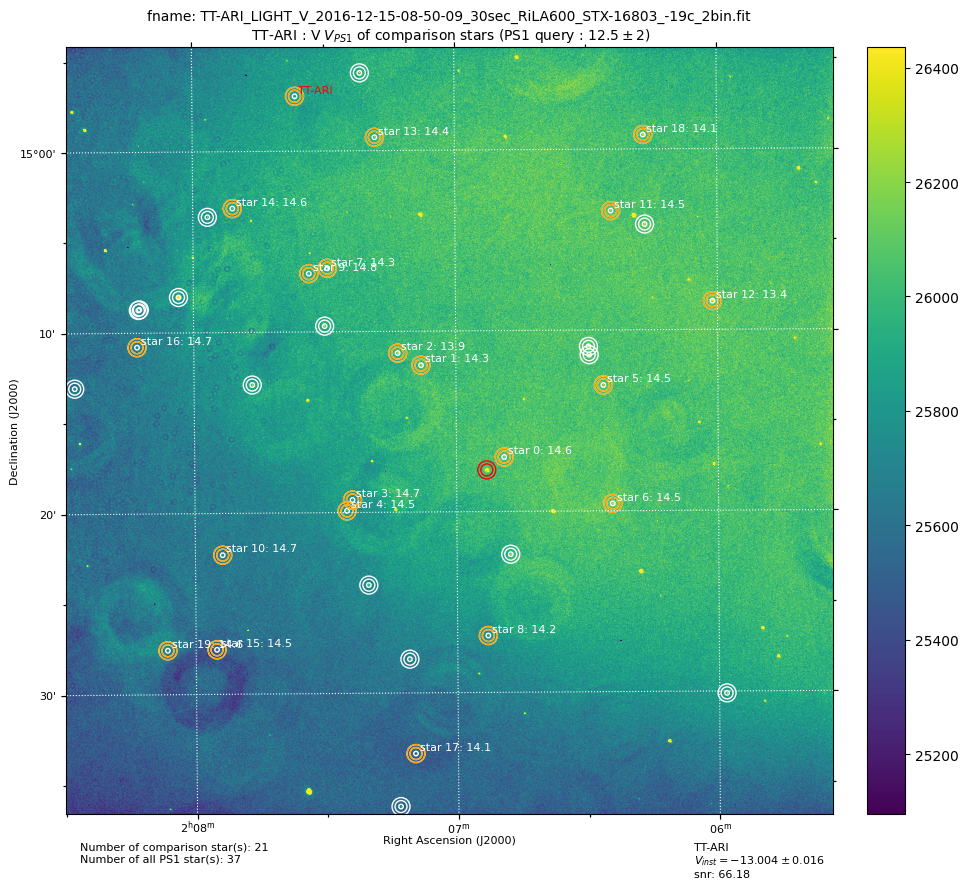

In [ ]:
#%%
#####################################################
# Plotting #1 f"{DIFFPRESULTDIR}/{fpath.stem}_PS1_magnitude.png"
#####################################################
fig, axs = plt.subplots(1, 1, figsize=val_figsize,
                        subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

im = _astro_utilities.zimshow(axs, hdul[0].data, )

ap_stars_all.plot(axs, color='w', lw=1)
# ap_stars.plot(axs, color='r', lw=1)

# ap_targ.plot(axs, color="r")
an_stars_all.plot(axs, color="w")
an_stars.plot(axs, color="orange")
an_targ.plot(axs, color="r")

for i, row in df_phot_PS1.iterrows():
        axs.text(row['xcenter']+10, row['ycenter']+10, f"star {i}: {row[f'{flt}mag']:.01f}", fontsize=8, color="w")  
        
try :
    axs.text(pos_pix_targ_init[0][0]+10, pos_pix_targ_init[1][0]+10, f"{targ_name}", fontsize=8, color="r")
except:
    pass
axs.coords.grid(True, color='white', ls=':')
axs.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
axs.coords['ra'].set_ticklabel_position('b')
axs.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
axs.coords['dec'].set_ticklabel_position('l')
axs.coords['ra'].set_major_formatter('hh:mm')
axs.coords['dec'].set_major_formatter('dd:mm')

axs.coords['ra'].display_minor_ticks(True)
axs.coords['dec'].display_minor_ticks(True)
axs.coords['ra'].set_minor_frequency(2)
axs.coords['dec'].set_minor_frequency(2)
axs.tick_params(labelsize=8)

cbar = plt.colorbar(im, ax = axs, fraction=val_fraction, pad=0.04, )

axs.set_title(f"fname: {fpath.name}\n {targ_name} : {flt} ${{{flt}}}_{{PS1}}$ of comparison stars (PS1 query : ${{{Mag_target}}} \pm {{{Mag_delta}}}$)", fontsize=10,)
axs.annotate(f'Number of comparison star(s): {len(pos_stars)}\nNumber of all PS1 star(s): {len(pos_stars_all)}', fontsize=8,
        xy=(0, 0), xytext=(10, -20), va='top', ha='left',
        xycoords='axes fraction', textcoords='offset points')
axs.annotate(f"{targ_name}\n${{{flt}}}_{{inst}} = {{{phot_targ['mag'][0]:+.03f}}} \pm {{{phot_targ['merr'][0]:.03f}}}$\nsnr: {phot_targ['snr'][0]:.02f}", fontsize=8,
        xy=(1, 0), xytext=(-100, -20), va='top', ha='left',
        xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_PS1_magnitude.png")
if verbose == True :
	print(f"{DIFFPRESULTDIR}/{fpath.stem}_PS1_magnitude.png is saved...")	
plt.show()

In [ ]:
#%%
######################################################
## Plotting #2 calculate error
######################################################
df_phot_stars = df_phot_PS1[df_phot_PS1["merr"] < ERR_Minimum]
# phot_stars_na = phot_stars_na.set_index('id', drop=True)
# df_phot_stars = df_phot_PS1_na.reset_index(drop=True)
if verbose == True :
    print("len(df_phot_stars):", len(df_phot_stars))
    print("df_phot_stars:\n", df_phot_stars)

merr_total1 = np.sqrt((df_phot_stars["merr"])**2 + (df_phot_stars[f"e_{flt}mag"])**2)

# === Calculate zero point and errors
_xx = np.linspace(Mag_target-Mag_delta, Mag_target+Mag_delta)
zeropt_med = np.median(df_phot_stars["mag"] - df_phot_stars[f"{flt}mag"])
# zeropt_avg = np.average(df_phot_stars["mag"] - df_phot_stars[f"{flt}mag"],
#                         weights=1/merr_total1**2)
dzeropt = np.max([1/np.sqrt(np.sum(1/(merr_total1)**2)),
                np.std((df_phot_stars[f"e_{flt}mag"] - df_phot_stars["merr"]), ddof=1)/np.sqrt(len(df_phot_stars[f"{flt}mag"]))])
merr_total2 = np.sqrt(np.sqrt(merr_total1**2 + dzeropt**2))

# === Find fitting lines
# Search for the usage of scipy.optimize.curve_fit.
# poptm, _ = curve_fit(_astro_utilities.linf, df_phot_stars[f"{flt}mag"],
#                     df_phot_stars["mag"],
#                     sigma= df_phot_stars["merr"], absolute_sigma=True)
# poptc, _ = curve_fit(_astro_utilities.linf, df_phot_stars["grcolor"],
#                     df_phot_stars["mag"] - df_phot_stars[f"{flt}mag"],
#                     sigma=merr_total2, absolute_sigma=True)

len(df_phot_stars): 9
df_phot_stars:
            _r    RAJ2000    DEJ2000               objID  cell  sky    f_objID  \
1    235.7028  31.783283  15.198071  126230317832808210  1598   77  235200512   
2    308.1780  31.805500  15.186790  126220318054964649  1598   77  235200512   
4    431.0064  31.854865  15.331804  126390318548448694  1598   87  503635968   
6    594.1008  31.601051  15.326582  126390316010422416  1598   87  503635968   
7    672.8940  31.872040  15.108114  126130318720320236  1598   77  503635968   
12   973.4976  31.504745  15.140291  126160315045948978  1598   77  570744832   
16  1070.6724  32.054150  15.179949  126210320541076481  1598   76  503635968   
17  1077.5124  31.790674  15.555894  126660317906547630  1598   87  503635968   
18  1173.1068  31.570266  14.986804  125980315702824769  1598   77  503635968   

    Qual  e_RAJ2000  e_DEJ2000  ...  nsky  nrej      aparea    source_sum  \
1     28     0.0083     0.0061  ...   999     3  113.097336  11214.501689 

## 그래프 추가중

In [89]:
#%%
df_phot_stars = df_phot_stars.dropna(subset=[f"{flt}mag", "mag", f"e_{flt}mag", "merr", "grcolor", "e_grcolor"])
if verbose == True :
    print("len(df_phot_stars):", len(df_phot_stars))
    print("df_phot_stars:\n", df_phot_stars)    
    print("len(df_phot_stars):", len(df_phot_stars))

len(df_phot_stars): 9
df_phot_stars:
            _r    RAJ2000    DEJ2000               objID  cell  sky    f_objID  \
1    235.7028  31.783283  15.198071  126230317832808210  1598   77  235200512   
2    308.1780  31.805500  15.186790  126220318054964649  1598   77  235200512   
4    431.0064  31.854865  15.331804  126390318548448694  1598   87  503635968   
6    594.1008  31.601051  15.326582  126390316010422416  1598   87  503635968   
7    672.8940  31.872040  15.108114  126130318720320236  1598   77  503635968   
12   973.4976  31.504745  15.140291  126160315045948978  1598   77  570744832   
16  1070.6724  32.054150  15.179949  126210320541076481  1598   76  503635968   
17  1077.5124  31.790674  15.555894  126660317906547630  1598   87  503635968   
18  1173.1068  31.570266  14.986804  125980315702824769  1598   77  503635968   

    Qual  e_RAJ2000  e_DEJ2000  ...  nsky  nrej      aparea    source_sum  \
1     28     0.0083     0.0061  ...   999     3  113.097336  11214.501689 

Text(0.5, 0.98, 'fname: TT-ARI_LIGHT_V_2016-12-15-08-50-09_30sec_RiLA600_STX-16803_-19c_2bin.fit\nPS1 check for differential photometry (PS1 query : ${12.5} \\pm {2}$), TT-ARI: ${V}_{result} = {11.104} \\pm {0.070}$')

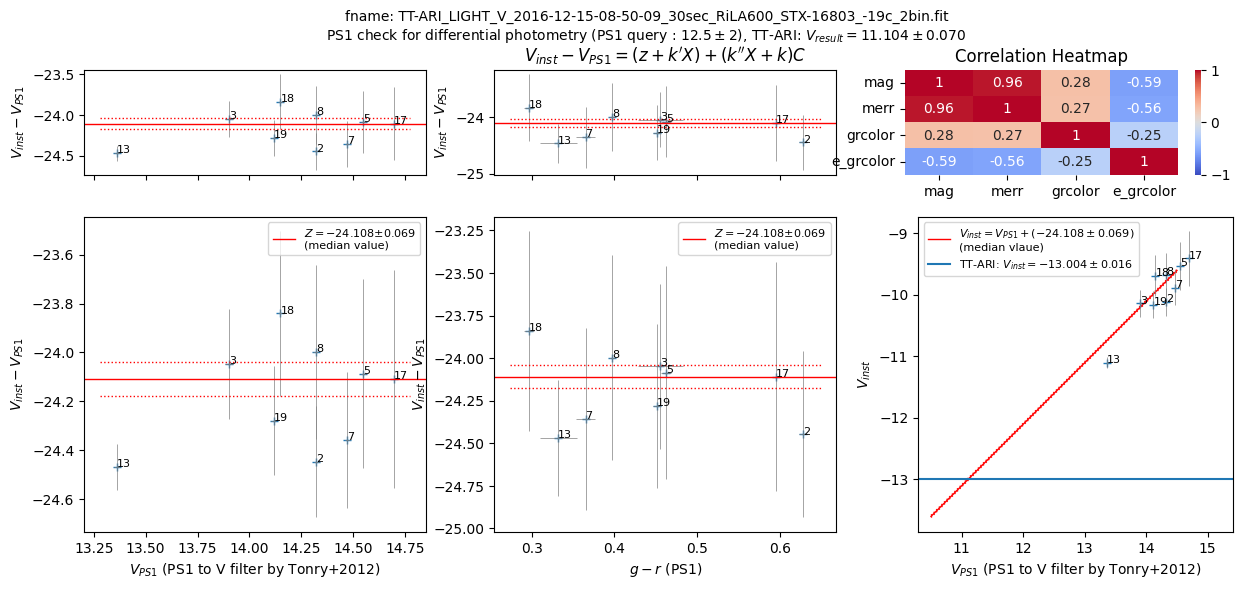

In [ ]:
#%%
######################################################
## Plotting #3 f"{DIFFPRESULTDIR}/{fpath.stem}_standardization.png"
######################################################
errkw = dict(marker="", ls="", ecolor="gray", elinewidth=0.5)

def plot_common(ax, x, y, xerr, yerr, title="", xlabel="", ylabel="", ylim=None):
    ax.plot(x, y, '+')
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, **errkw)
    ax.axhline(zeropt_med, color="r", lw=1, label=f"$Z = {{{zeropt_med:.3f}}} ± {{{dzeropt:.3f}}}$\n(median value)")
    # ax.axhline(zeropt_avg, color="b", lw=1, label=f"$Z = {{{zeropt_avg:.3f}}} ± {{{dzeropt:.3f}}}$\n(average value)")
    ax.hlines([zeropt_med + dzeropt, zeropt_med - dzeropt, 
                # zeropt_avg + dzeropt, zeropt_avg - dzeropt
                ],
            *ax.get_xlim(), color=["r","r","b","b"], lw=1, ls=":")
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel, ylim=ylim)
    # ax.legend(fontsize=8, loc='best')

fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharex=False, sharey=False,
                gridspec_kw={'height_ratios': [1, 3]})

# 상단 행
plot_common(axs[0, 0], df_phot_stars[f"{flt}mag"], df_phot_stars["mag"] - df_phot_stars[f"{flt}mag"],
                df_phot_stars[f"e_{flt}mag"], df_phot_stars["merr"],
                ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$",
                # ylim=(zeropt_med-0.8, zeropt_med+0.8),
            )

plot_common(axs[0, 1], df_phot_stars["grcolor"], df_phot_stars["mag"] - df_phot_stars[f"{flt}mag"],
                df_phot_stars[f"e_grcolor"], merr_total2,
                title=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}} = (z + k'X) + (k''X + k)C$",
                ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$",
            # ylim=(zeropt_med-0.8, zeropt_med+0.8),
            )
# axs[0, 1].plot(axs[0, 1].get_xlim(), _astro_utilities.linf(np.array(axs[0, 1].get_xlim()), *poptc),
#             "g-", lw=1, label=f"$y = {{{poptc[1]:+.3f}}}x {{{poptc[0]:+.3f}}}$\n(curve_fit)")
# axs[0, 1].legend(fontsize=8, loc='best')

data = df_phot_stars[["mag", "merr", "grcolor", "e_grcolor"]]
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, ax=axs[0, 2])
axs[0, 2].set(title='Correlation Heatmap')

# 하단 행
plot_common(axs[1, 0], df_phot_stars[f"{flt}mag"], df_phot_stars["mag"] - df_phot_stars[f"{flt}mag"],
                    df_phot_stars[f"e_{flt}mag"], df_phot_stars["merr"],
                    xlabel=f"${{{flt}}}_{{PS1}}$ (PS1 to {flt} filter by Tonry+2012)",
                    ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$")

plot_common(axs[1, 1], df_phot_stars["grcolor"], df_phot_stars["mag"] - df_phot_stars[f"{flt}mag"],
                    df_phot_stars[f"e_grcolor"], merr_total2,
                    xlabel="$g - r$ (PS1)",
                    ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$")
axs[1, 0].legend(fontsize=8, loc='best')

# axs[1, 1].plot(axs[1, 1].get_xlim(), _astro_utilities.linf(np.array(axs[1, 1].get_xlim()), *poptc),
#             "g-", lw=1, label=f"$y = {{{poptc[1]:+.3f}}}x {{{poptc[0]:+.3f}}}$\n(curve_fit)")
axs[1, 1].legend(fontsize=8, loc='best')

axs[1, 2].plot(_xx, _xx + zeropt_med,
                    label=f"${{{flt}}}_{{inst}} = {{{flt}}}_{{PS1}}+({{{zeropt_med:.3f}}} \pm {{{dzeropt:.3f}}})$\n(median vlaue)",
                    color="r", lw=1, ls="-")
axs[1, 2].plot(_xx, _xx + zeropt_med+phot_targ['merr'][0],
                    color="r", lw=1, ls=":")
axs[1, 2].plot(_xx, _xx + zeropt_med-phot_targ['merr'][0],
                    color="r", lw=1, ls=":")
# axs[1, 2].plot(axs[1, 2].get_xlim(), _astro_utilities.linf(np.array(axs[1, 2].get_xlim()), *poptm),
#             "g-", lw=1, label=f"$y = {{{poptm[1]:.3f}}}x {{{poptm[0]:+.3f}}}$\n(curve_fit)")
axs[1, 2].plot(df_phot_stars[f"{flt}mag"], df_phot_stars["mag"], '+')
axs[1, 2].axhline(phot_targ["mag"].values, label=f"{targ_name}: ${{{flt}}}_{{inst}} = {{{phot_targ['mag'][0]:+.03f}}} \pm {{{phot_targ['merr'][0]:.03f}}}$")
# axs[1, 2].axhline([phot_targ["mag"].values + phot_targ['merr'][0], phot_targ["mag"].values - phot_targ['merr'][0]],
#                   *axs[1, 2].get_xlim(), color=["b","b"], lw=1, ls=":")
axs[1, 2].axhline(phot_targ["mag"].values + phot_targ['merr'][0],
                    *axs[1, 2].get_xlim(), color="b", lw=1, ls=":")
axs[1, 2].axhline(phot_targ["mag"].values - phot_targ['merr'][0],
                    *axs[1, 2].get_xlim(), color="b", lw=1, ls=":")
axs[1, 2].errorbar(df_phot_stars[f"{flt}mag"],
                    df_phot_stars["mag"],
                    xerr=df_phot_stars[f"e_{flt}mag"],
                    yerr=df_phot_stars["merr"],
                    **errkw)
axs[1, 2].set(
                    xlabel=f"${{{flt}}}_{{PS1}}$ (PS1 to {flt} filter by Tonry+2012)",
                    ylabel =f"${{{flt}}}_{{inst}}$",
        )
axs[1, 2].legend(fontsize=8, loc='best')
axs[1, 2].axis('square')

# ID 텍스트 추가
for _, row in df_phot_stars.iterrows():
    for i in range(2):
        for j in range(2):
            axs[i, j].text(row[f"{flt}mag" if j == 0 else "grcolor"],
                        row["mag"] - row[f"{flt}mag"], int(row["id"]), fontsize=8, clip_on=True)
    axs[1, 2].text(row[f"{flt}mag"], row["mag"], int(row["id"]), fontsize=8, clip_on=True)

# x축 레이블 숨기기 (상단 행)
for ax in axs[0, :2]:
    ax.tick_params(labelbottom=False)

plt.suptitle(f"fname: {fpath.name}\nPS1 check for differential photometry (PS1 query : ${{{Mag_target}}} \pm {{{Mag_delta}}}$), {targ_name}: ${{{flt}}}_{{result}} = {{{(phot_targ['mag'][0]-zeropt_med):.3f}}} \pm {{{(np.sqrt((dzeropt)**2+(phot_targ['merr'][0])**2)):.03f}}}$", fontsize=10)


In [91]:
df_phot_stars.columns


Index(['_r', 'RAJ2000', 'DEJ2000', 'objID', 'cell', 'sky', 'f_objID', 'Qual',
       'e_RAJ2000', 'e_DEJ2000', '_tab1_10', 'Ns', 'Nd', 'Ng', 'Nr', 'Ni',
       'Nz', 'Ny', 'gPSFf', 'gmag', 'e_gmag', 'gmagStd', 'o_gmag', 'b_gmag',
       'B_gmag', 'gKmag', 'e_gKmag', 'gFlags', 'rPSFf', 'rmag', 'e_rmag',
       'rmagStd', 'o_rmag', 'b_rmag', 'B_rmag', 'rKmag', 'e_rKmag', 'rFlags',
       'iPSFf', 'imag', 'e_imag', 'imagStd', 'o_imag', 'b_imag', 'B_imag',
       'iKmag', 'e_iKmag', 'iFlags', 'zPSFf', 'zmag', 'e_zmag', 'zmagStd',
       'o_zmag', 'b_zmag', 'B_zmag', 'zKmag', 'e_zKmag', 'zFlags', 'yPSFf',
       'ymag', 'e_ymag', 'ymagStd', 'o_ymag', 'b_ymag', 'B_ymag', 'yKmag',
       'e_yKmag', 'yFlags', 'x', 'y', 'grcolor', 'e_grcolor', 'Bmag', 'e_Bmag',
       'Vmag', 'e_Vmag', 'Rmag', 'e_Rmag', 'id', 'xcenter', 'ycenter',
       'aperture_sum', 'aperture_sum_err', 'msky', 'ssky', 'nsky', 'nrej',
       'aparea', 'source_sum', 'source_sum_err', 'mag', 'merr', 'snr', 'bad',
       'nbadp

In [ ]:
#%%
#####################################################
# createf"{DIFFPRESULTDIR}/{fpath.stem}_result_photometry.csv"
#####################################################
df_phot_PS1 = pd.concat([df_phot_PS1, phot_targ], axis=0)
df_phot_PS1 = df_phot_PS1.reset_index(drop=True)
if verbose==True :
    print("df_phot_PS1:\n", df_phot_PS1)
    print("df_phot_PS1.columns:", df_phot_PS1.columns)    
    print("len(df_phot_PS1):", len(df_phot_PS1))    
print(len(df_phot_PS1))
df_phot_PS1.at[len(df_phot_PS1)-1, 'OBJ'] = targ_name
df_phot_PS1.at[len(df_phot_PS1)-1, 'RAJ2000'] = pos_sky_targ_init.ra.degree
df_phot_PS1.at[len(df_phot_PS1)-1, 'DEJ2000'] = pos_sky_targ_init.dec.degree
if verbose==True :
    print("df_phot_PS1:\n", df_phot_PS1)
    print("df_phot_PS1.columns:", df_phot_PS1.columns)    
    print("len(df_phot_PS1):", len(df_phot_PS1))  

df_phot_PS1['filename'] = fpath.stem
df_phot_PS1['t_start'] = t_start
df_phot_PS1['t_expos'] = t_expos
df_phot_PS1['t_middle'] = t_middle
df_phot_PS1['filter'] = flt
df_phot_PS1["zeropt_med"] = zeropt_med
# df_phot_PS1["zeropt_avg"] = zeropt_avg
df_phot_PS1["e_zeropt"] = dzeropt

df_phot_PS1[f"{flt}_magnitude"] = df_phot_PS1["mag"] - df_phot_PS1["zeropt_med"]
df_phot_PS1[f"{flt}_magerr"] = np.sqrt((dzeropt)**2+(df_phot_PS1['merr'])**2)
if verbose == True :
    print("df_phot_PS1:\n", df_phot_PS1)
    print("len(df_phot_PS1): ", len(df_phot_PS1))

df_phot_PS1.to_csv(f"{DIFFPRESULTDIR}/{fpath.stem}_result_photometry.csv")
if verbose == True :
    print(f"{DIFFPRESULTDIR}/{fpath.stem}_result_photometry.csv is saved...")   

df_phot_PS1:
            _r    RAJ2000    DEJ2000         objID    cell   sky      f_objID  \
0    202.6692  31.704460  15.283191  1.263403e+17  1598.0  87.0  503635968.0   
1    235.7028  31.783283  15.198071  1.262303e+17  1598.0  77.0  235200512.0   
2    308.1780  31.805500  15.186790  1.262203e+17  1598.0  77.0  235200512.0   
3    394.8156  31.849570  15.321821  1.263803e+17  1598.0  87.0  503635968.0   
4    431.0064  31.854865  15.331804  1.263903e+17  1598.0  87.0  503635968.0   
5    533.3148  31.609298  15.217353  1.262603e+17  1598.0  87.0  503635968.0   
6    594.1008  31.601051  15.326582  1.263903e+17  1598.0  87.0  503635968.0   
7    672.8940  31.872040  15.108114  1.261303e+17  1598.0  77.0  503635968.0   
8    692.7156  31.720719  15.447610  1.265303e+17  1598.0  87.0  503635968.0   
9    697.9572  31.889714  15.112959  1.261303e+17  1598.0  77.0  503635968.0   
10   857.4408  31.973990  15.371785  1.264403e+17  1598.0  86.0  503635968.0   
11   904.7772  31.601391  

In [94]:
#%%
df_phot_PS1_na = df_phot_PS1.dropna(subset=[f"{flt}mag", "mag", f"e_{flt}mag", "merr", "grcolor", "e_grcolor"])
if verbose == True :
    print("len(df_phot_PS1_na):", len(df_phot_PS1_na))
    print("df_phot_stars:\n", df_phot_PS1_na)    
    print("len(df_phot_PS1_na):", len(df_phot_PS1_na))

len(df_phot_PS1_na): 21
df_phot_stars:
            _r    RAJ2000    DEJ2000         objID    cell   sky      f_objID  \
0    202.6692  31.704460  15.283191  1.263403e+17  1598.0  87.0  503635968.0   
1    235.7028  31.783283  15.198071  1.262303e+17  1598.0  77.0  235200512.0   
2    308.1780  31.805500  15.186790  1.262203e+17  1598.0  77.0  235200512.0   
3    394.8156  31.849570  15.321821  1.263803e+17  1598.0  87.0  503635968.0   
4    431.0064  31.854865  15.331804  1.263903e+17  1598.0  87.0  503635968.0   
5    533.3148  31.609298  15.217353  1.262603e+17  1598.0  87.0  503635968.0   
6    594.1008  31.601051  15.326582  1.263903e+17  1598.0  87.0  503635968.0   
7    672.8940  31.872040  15.108114  1.261303e+17  1598.0  77.0  503635968.0   
8    692.7156  31.720719  15.447610  1.265303e+17  1598.0  87.0  503635968.0   
9    697.9572  31.889714  15.112959  1.261303e+17  1598.0  77.0  503635968.0   
10   857.4408  31.973990  15.371785  1.264403e+17  1598.0  86.0  503635968.0   


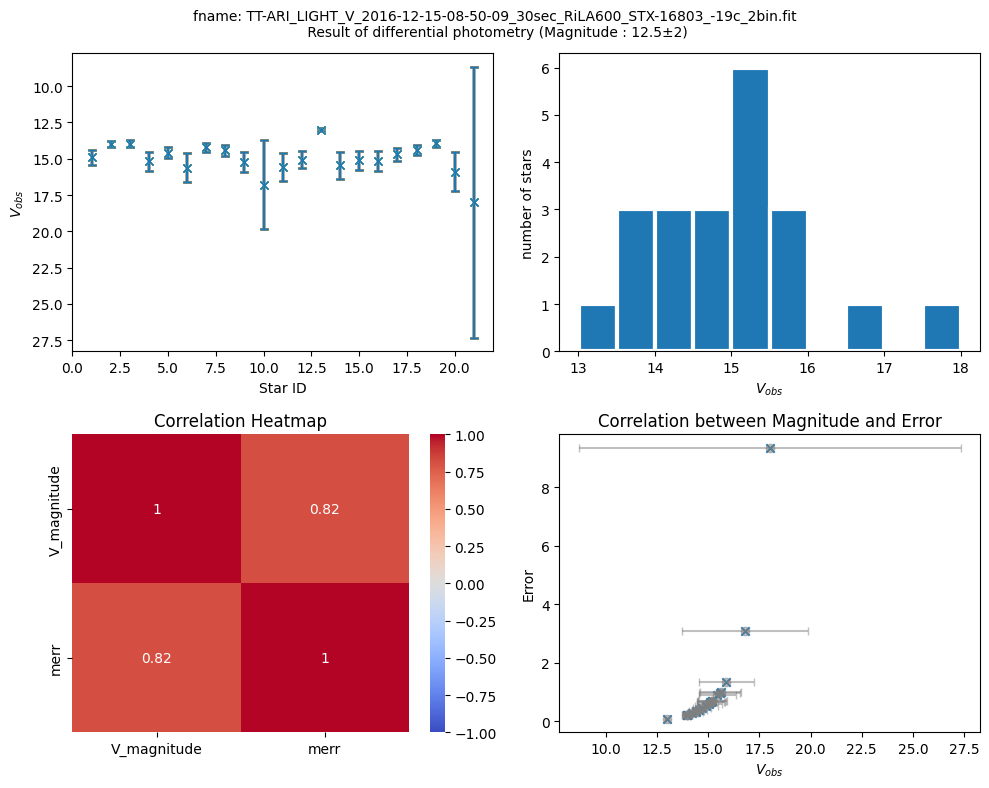

In [95]:
#%%
######################################################
## Plotting #5 f"{DIFFPRESULTDIR}/{fpath.stem}_Result_of_differential_photometry.png"
######################################################
fig, axs = plt.subplots(2, 2, figsize=(10, 8),
                        sharex=False, sharey=False, gridspec_kw=None)

for idx, row in df_phot_PS1_na.iterrows():
    im0 = axs[0, 0].errorbar(df_phot_PS1_na["id"],
                df_phot_PS1_na[f"{flt}_magnitude"], yerr=df_phot_PS1_na["merr"],
                marker='x',
                ls='none',
                #ms=10,
                capsize=3)

axs[0, 0].invert_yaxis()
axs[0, 0].set(
    xlabel='Star ID',
    ylabel=f"${{{flt}}}_{{obs}}$"
    )

style = {'edgecolor': 'white', 'linewidth': 3}
im1 = axs[0, 1].hist(df_phot_PS1_na[f"{flt}_magnitude"],
            **style)
axs[0, 1].set(
    xlabel=f"${{{flt}}}_{{obs}}$",
    ylabel="number of stars"
    )

# 상관관계 계산
data =  df_phot_PS1_na[[f"{flt}_magnitude", "merr"]]
corr = data.corr()

# 히트맵 그리기
im2 = sns.heatmap(corr, annot=True, cmap='coolwarm',
                    vmin=-1, vmax=1, center=0, ax = axs[1, 0])
axs[1, 0].set(
    title = 'Correlation Heatmap',
    )

axs[1, 1].scatter(df_phot_PS1_na[f"{flt}_magnitude"], df_phot_PS1_na["merr"], marker='x',)
axs[1, 1].errorbar(x=df_phot_PS1_na[f"{flt}_magnitude"], y=df_phot_PS1_na["merr"],
            yerr=None, xerr=df_phot_PS1_na["merr"], fmt="o", color="gray", capsize=3, alpha=0.5)
axs[1, 1].set(
    title = "Correlation between Magnitude and Error",
    xlabel=f"${{{flt}}}_{{obs}}$",
    ylabel="Error",
    )

plt.suptitle(f"fname: {fpath.name}\n Result of differential photometry (Magnitude : {Mag_target}±{Mag_delta})", fontsize=10,)
plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_Result_of_differential_photometry.png")
# plt.show()